<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Code for Prolific Analysis</h1>
<h4 style="margin-top: 0.7em; margin-bottom: 0.3em; font-style:italic">LEIA vs. Humans - Masterthesis</h4>
</div>
<br>

In [126]:


from statsmodels.stats.contingency_tables import mcnemar

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np  
from transformers import pipeline
import random
from tqdm import tqdm
import pandas as pd
import json

import colorsys
import matplotlib.colors as mcolors

import math
import matplotlib.patches as mpatches

from openai import OpenAI

from huggingface_hub import login



In [127]:
emotions = ["Anger", "Fear", "Happiness", "Sadness"]


## Step 1: Load files



In [ ]:
annotator_df = pd.read_csv('exp1_annotator_individual_df.csv', index_col = 0)
anno_maj_aggr_emot = pd.read_csv('exp1_annotator_majority_df.csv', index_col = 0)
vent = pd.read_csv('vent_equal_pilot_checked.csv', index_col = 0)

## Other models

In [137]:

API_TOKEN = ''

login(token = API_TOKEN)

In [148]:
def create_prompt(text):
    """Create prompt used for all LLMs

    Args: 
        text to label
    

    Retruns:
        complete prompt per text for the LLM with randomly selected example - 1-shot
    
    """
    


    label_prompt = f""" Given a piece of text, you have to label to which of the following emotions
                        it corresponds. The options are: Fear, Happiness, Sadness, Anger. Do not
                        choose any other emotion. Please return only one of the previous options as
                        a single word. Do not provide an explanation.
            """
    task = f"""What is the label of this text: {text} """

    example_row = vent.sample(1).iloc[0]
    example = f"text: {example_row['text']}, emotion: {example_row['sentiment']}"
    
    messages = [
        {"role": "system", "content": label_prompt},
        {"role": "user", "content": example},
        {"role": "user", "content": task}
    ]

    return messages

In [149]:
api_key = ''

In [315]:


models = {
    "roberta_goemotions": "SamLowe/roberta-base-go_emotions",
    "distilroberta_emotion": "j-hartmann/emotion-english-distilroberta-base"
}

pipelines = {
    name: pipeline("text-classification", model=mdl, tokenizer=mdl, top_k=None)
    for name, mdl in models.items()
}

for name, pipe in pipelines.items():
    print(f"Running predictions with {name}...")
    anno,anno_maj_aggr_emot[name + "_prediction"] = anno,anno_maj_aggr_emot['text'].progress_apply(lambda x: pipe(x))



Device set to use cpu
Device set to use cpu


Running predictions with roberta_goemotions...


100%|██████████| 1000/1000 [01:07<00:00, 14.71it/s]


Running predictions with distilroberta_emotion...


100%|██████████| 1000/1000 [00:37<00:00, 26.48it/s]


In [316]:
emotions_lower = ['sadness', 'joy', 'anger', 'fear']

def get_emotion_scores(df, model, short_model):
    """Retrieve the scores of all emotions from RoBERta models and retrieve emotion with top score from valid list of emotions

    Args:
        df (dataframe): dataframe for all texts
        model (str): name of the model
        short_model (str): short name to be used as column value

    Returns:
        dataframe: dataframe with additional column of respective model
    """
    df = df.copy()

    for idx in df.index:
        predictions = df.at[idx, model][0]
        filtered = [emotion for emotion in predictions if emotion['label'].lower() in emotions_lower]

        emotion_scores = {emotion: 0.0 for emotion in emotions_lower}

        for item in filtered:
            label = item['label'].lower()
            score = item['score']
            if label in emotion_scores:
                emotion_scores[label] = score  

        for emotion in emotions_lower:
            df.at[idx, f'{short_model}_{emotion}'] = emotion_scores[emotion]

        # Determine top emotion
        top_emotion = max(emotion_scores.items(), key=lambda x: x[1])
        if top_emotion[1] > 0:
            df.at[idx, f'{short_model}_label'] = top_emotion[0].capitalize()
        else:
            df.at[idx, f'{short_model}_label'] = None

    return df
# First for roberta
exp1_models = get_emotion_scores(anno_maj_aggr_emot, model='roberta_goemotions_prediction', short_model='roberta')

# Then for distilroberta
exp1_models = get_emotion_scores(exp1_models, model='distilroberta_emotion_prediction', short_model='distilroberta')



In [ ]:
emotions_lower = ['sadness', 'joy', 'anger', 'fear']
lengths = []
def get_top_emotion(df, model):

    """Retrieve top emotion from model answers

    Returns:
        dataframe: dataframe with extracted top emotion
    """
    df = df.copy()


    for idx in df.index:
        predictions = df.loc[idx, model][0]
        filtered = [emotion for emotion in predictions if emotion['label'].lower() in emotions_lower]
        lengths.append(len(filtered))
        if filtered:
            top = max(filtered, key=lambda x: x['score'])
            df.loc[idx, f'{model}_top_emotion'] = top['label'].capitalize()
            df.loc[idx, f'{model}_top_score'] = top['score']
        else:
            df.loc[idx, f'{model}_top_emotion'] = None
            df.loc[idx, f'{model}_top_score'] = None

    return df

roberta_labeled = get_top_emotion(exp1_models, 'roberta_goemotions_prediction')
exp1_models= get_top_emotion(roberta_labeled, 'distilroberta_emotion_prediction')



In [44]:

def run_gpt(df, model):

    """Run GPT API on dataframe

    Returns:
        dataframe: dataframe containing GPT's answers for every text
    """
    client = OpenAI(api_key=api_key)


    output_list = []

    for i, row in tqdm(df.iterrows(), desc="Processing labeling", total=df.shape[0]):  
        preds = []
        for n in range(0, 3):
            response = client.responses.create(
                model=model,
                input=create_prompt(row['text'])
            )
            
            preds.append(response.output_text)

        row_dict = row.to_dict()
        row_dict.update({
            'pred_1': preds[0],
            'pred_2': preds[1],
            'pred_3': preds[2]
        })

        output_list.append(row_dict)
    result = pd.DataFrame(output_list)



    return result
   
def majority_calculation(df, model, label_cols=emotions):
    """from all 3 runs, get the majority answer. Choose one at random if equal

    Args:
        df (dataframe): dataframe containing 3 predictions per model
        model (str): name of the model for which we get majority vote
        label_cols (list, optional): emotion columns. Defaults to emotions.
    """

    def find_max(row):
        max_count = row[label_cols].value_counts().max()  # Get max count
        max_labels = row[label_cols].value_counts()[row[label_cols].value_counts() == max_count].index.tolist()
        return random.choice(max_labels) if len(max_labels) > 1 else max_labels[0]  # Choose randomly if tie
    
    df[f'{model}_label'] = df.apply(find_max, axis=1)  # Apply to each row
    
    return df






In [150]:




#anno_maj_aggr_emot = anno_maj_aggr_emot.loc[:, ~anno_maj_aggr_emot.columns.str.startswith('Unnamed')]


# gpt2 = run_gpt(working_df, 'gpt-4o')

# gpt2 = majority_calculation(gpt2, 'gpt_4o',['pred_1', 'pred_2', 'pred_3'])


# gpt2.to_csv('anno_maj_labeled_gpt.csv')


# gpt = run_gpt(gpt2, 'gpt-4o-mini')

# gpt = majority_calculation(gpt, 'gpt_4o_mini',['pred_1', 'pred_2', 'pred_3'])
# gpt.to_csv('anno_maj_labeled.csv')



#gpt= run_leia_wo_affection(gpt)


#gpt2.to_csv('anno_maj_labeled_gpt.csv')



the following code is extracted from files I used on the server, to show how I called the models, but does not work if no GPU

In [154]:
def run_llama(df, pipeline):

    """Run the llama models on the dataframe
    
    Args:
        df (dataframe): containing text the model should label
        pipeline : previously defined pipeline of the model

    Returns:
        dataframe containing predictions
    """
    output_list = []
    for i, row in tqdm(df.iterrows(), desc="Processing labeling", total=df.shape[0]):    
        preds = []
        for n in range(0, 3):
            
            outputs = pipeline(
                create_prompt(row['text']),
                max_new_tokens=50,
                temperature = 0.4,
                pad_token_id=pipeline.tokenizer.eos_token_id  # Set pad_token_id explicitly
            )
            
            answer = outputs[0]['generated_text'][-1]['content']
            preds.append(answer)

        row_dict = row.to_dict()
        row_dict.update({
            'pred_1': preds[0],
            'pred_2': preds[1],
            'pred_3': preds[2]
        })

        output_list.append(row_dict)
    result = pd.DataFrame(output_list)



    #llama_label["Leia_Label"] = llama_label["Leia_Label"].replace({"Happiness": "Joy"})

    return result

In [155]:
def run_qwen(df, model, tokenizer):

    """Run qwen models on the dataframe

    
    Args:
        df (dataframe): containing text the model should label
        model and tokenizer : previously defined for the model

    Returns:
        dataframe containing predictions
    """
    
    output_list = []
    
    for idx, row in tqdm(df.iterrows(), desc="Processing labels", total=df.shape[0]):    
        preds = []
        for n in range(0, 3):
            text = tokenizer.apply_chat_template(create_prompt(row['text']),
                tokenize=False,
                add_generation_prompt=True,
                enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
            )
            model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
            
            # conduct text completion
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=32768
            )
            output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 
            
            # parsing thinking content
            try:
                # rindex finding 151668 (</think>)
                index = len(output_ids) - output_ids[::-1].index(151668)
            except ValueError:
                index = 0
            
            content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")
            preds.append(content)
            
        row_dict = row.to_dict()
        row_dict.update({
            'pred_1': preds[0],
            'pred_2': preds[1],
            'pred_3': preds[2]
        })

        output_list.append(row_dict)
    result = pd.DataFrame(output_list)


    return result


### Load file containing all labels

In [ ]:
all_models_clean = pd.read_csv('anno_maj_labeled.csv', index_col = 0).drop(columns=['pred_1', 'pred_2', 'pred_3'])
all_models_clean

#### 2.1.1 Humans vs LEIA without bootstrapping

In [36]:
from sklearn.metrics import f1_score


In [38]:
annotator_df_merged = annotator_df.merge(
    all_models_clean[['text', 'instance_id', 'llama31_label', 'llama33_label', 'roberta_label',
       'distilroberta_label', 'gpt_4o_label', 'gpt_4o_mini_label',
       'gpt_4_5_label', 'gpt_4_1_label', 'gpt_4_1_mini_label', 'qwen3_32B_label']],
    on=['text', 'instance_id'],
    how='left'
)




## Metrics without differentiating between individuals

In [40]:

label_dict = {
    'Humans': 'label',
    'LEIA': 'Leia_Label',
    'RoBERTa GoEmotions': 'roberta_label',
    'Emotion DistilRoBERTa': 'distilroberta_label',
    'Llama 3.3': 'llama33_label',
    'Llama 3.1': 'llama31_label',
    'GPT 4.5-preview': 'gpt_4_5_label',
    'GPT 4.1': 'gpt_4_1_label',
    'GPT 4o': 'gpt_4o_label',     
    'GPT 4.1-mini': 'gpt_4_1_mini_label',
    'GPT 4o-mini': 'gpt_4o_mini_label',
    'Qwen 3 32B': 'qwen3_32B_label'

}



group_order = {
    "Humans": ["Humans"],
    "Leia": ["LEIA"],
    "Roberta": ["RoBERTa GoEmotions", "Emotion DistilRoBERTa"],
    "LLaMA": ["Llama 3.3", "Llama 3.1"],
    "GPT": ["GPT 4.5-preview","GPT 4.1", "GPT 4o", "GPT 4.1-mini", "GPT 4o-mini"],
    "Qwen": ['Qwen 3 32B']
}



group_base_colors = {
    'Humans': '#7bc8f6',     # blue
    'Leia': '#ffa500',      # gold
    'Roberta': '#2ca02c',   # green
    'LLaMA': '#9467bd',     # purple
    'GPT': '#d62728',       # red
    'Qwen': '#ff81c0',      # pink
}




In [41]:


def generate_similar_colors(base_hex, n):
    """Generate `n` visually distinct but similar colors from a base hex color."""
    base_rgb = mcolors.to_rgb(base_hex)
    base_hls = colorsys.rgb_to_hls(*base_rgb)

    colors = []
    for i in range(n):
        # Shift hue slightly to generate variations (±0.05 per step)
        hue_shift = (i - n // 2) * 0.05
        new_hue = (base_hls[0] + hue_shift) % 1.0
        # Keep lightness and saturation the same
        new_rgb = colorsys.hls_to_rgb(new_hue, base_hls[1], base_hls[2])
        colors.append(new_rgb)
    return colors

model_colors = {}

for group, readable_names in group_order.items():
    base_color = group_base_colors[group]
    n = len(readable_names)
    
    similar_colors = generate_similar_colors(base_color, n)
    for name, color in zip(readable_names, similar_colors):
        model_colors[name] = color



In [44]:
#bootstrapping for individual values dataframe

boot_n = 1000

macro_boot_results = {}
per_emotion_boot_results = {}
emotions = ["Anger", "Fear", "Happiness", "Sadness"]

for model, label_col in tqdm(label_dict.items()):
    df = annotator_df_merged.copy()
    df = df[~df[label_col].isna()]

    macro_scores = []
    emotion_scores = {e: [] for e in emotions}

    for _ in range(boot_n):
        boot_df = df.sample(frac=1, replace=True)

        try:
            # Macro F1
            macro = f1_score(boot_df['true_label'], boot_df[label_col], average='macro')
            macro_scores.append(macro)

            # Per-emotion F1
            for emotion in emotions:
                y_true = (boot_df['true_label'] == emotion).astype(int)
                y_pred = (boot_df[label_col] == emotion).astype(int)

                if y_true.sum() > 0: 
                    emo_f1 = f1_score(y_true, y_pred)
                    emotion_scores[emotion].append(emo_f1)
        except Exception:
            continue

    macro_boot_results[model] = {
        "mean": np.mean(macro_scores),
        "lower": np.percentile(macro_scores, 2.5),
        "upper": np.percentile(macro_scores, 97.5)
    }

    per_emotion_boot_results[model] = {
        emotion: {
            "mean": np.mean(scores),
            "lower": np.percentile(scores, 2.5),
            "upper": np.percentile(scores, 97.5)
        }
        for emotion, scores in emotion_scores.items()
    }


100%|██████████| 12/12 [12:10<00:00, 60.91s/it]


In [102]:
# bootstrapping for annotator majority dataframe
boot_n = 1000

macro_boot_results_majority = {}
per_emotion_boot_results_majority = {}
label_dict['Humans'] = 'annotator_majority'
for model, label_col in tqdm(label_dict.items()):
    df = all_models_clean.copy()
    df = df[~df[label_col].isna()]

    macro_scores = []
    emotion_scores = {e: [] for e in emotions}

    for _ in range(boot_n):
        boot_df = df.sample(frac=1, replace=True)

        try:
            # Macro F1
            macro = f1_score(boot_df['true_label'], boot_df[label_col], average='macro')
            macro_scores.append(macro)

            # Per-emotion F1
            for emotion in emotions:
                
                y_true = (boot_df['true_label'] == emotion).astype(int)
                y_pred = (boot_df[label_col] == emotion).astype(int)

                if y_true.sum() > 0:  
                    emo_f1 = f1_score(y_true, y_pred)
                    emotion_scores[emotion].append(emo_f1)
        except Exception:
            continue

    # Store macro results
    macro_boot_results_majority[model] = {
        "mean": np.mean(macro_scores),
        "lower": np.percentile(macro_scores, 2.5),
        "upper": np.percentile(macro_scores, 97.5)
    }

    # Store per-emotion results
    per_emotion_boot_results_majority[model] = {
        emotion: {
            "mean": np.mean(scores),
            "lower": np.percentile(scores, 2.5),
            "upper": np.percentile(scores, 97.5)
        }
        for emotion, scores in emotion_scores.items()
    }


100%|██████████| 12/12 [04:05<00:00, 20.46s/it]


In [45]:
# Extract macro_f1s and error bars from bootstrapping results
macro_f1s = {model: macro_boot_results[model] for model in macro_boot_results}

positions = []
labels = []
colors = []
f1_scores = []
yerr_lower = []
yerr_upper = []

current_x = 0
gap = 0.5  # space between groups

for group, models in group_order.items():
    for model in models:
        if model in macro_f1s:  # skip missing models
            score = macro_f1s[model]["mean"]
            lower = macro_f1s[model]["lower"]
            upper = macro_f1s[model]["upper"]

            positions.append(current_x)
            labels.append(model)
            colors.append(model_colors[model])
            f1_scores.append(score)
            yerr_lower.append(score - lower)
            yerr_upper.append(upper - score)
            current_x += 1
    current_x += gap


In [103]:
# Extract macro_f1s and error bars from bootstrapping results
macro_f1s = {model: macro_boot_results_majority[model] for model in macro_boot_results_majority}

positions = []
labels = []
colors = []
f1_scores = []
yerr_lower = []
yerr_upper = []

current_x = 0
gap = 0.5  # space between groups

for group, models in group_order.items():
    for model in models:
        if model in macro_f1s:  # skip missing models
            score = macro_f1s[model]["mean"]
            lower = macro_f1s[model]["lower"]
            upper = macro_f1s[model]["upper"]

            positions.append(current_x)
            labels.append(model)
            colors.append(model_colors[model])
            f1_scores.append(score)
            yerr_lower.append(score - lower)
            yerr_upper.append(upper - score)
            current_x += 1
    current_x += gap


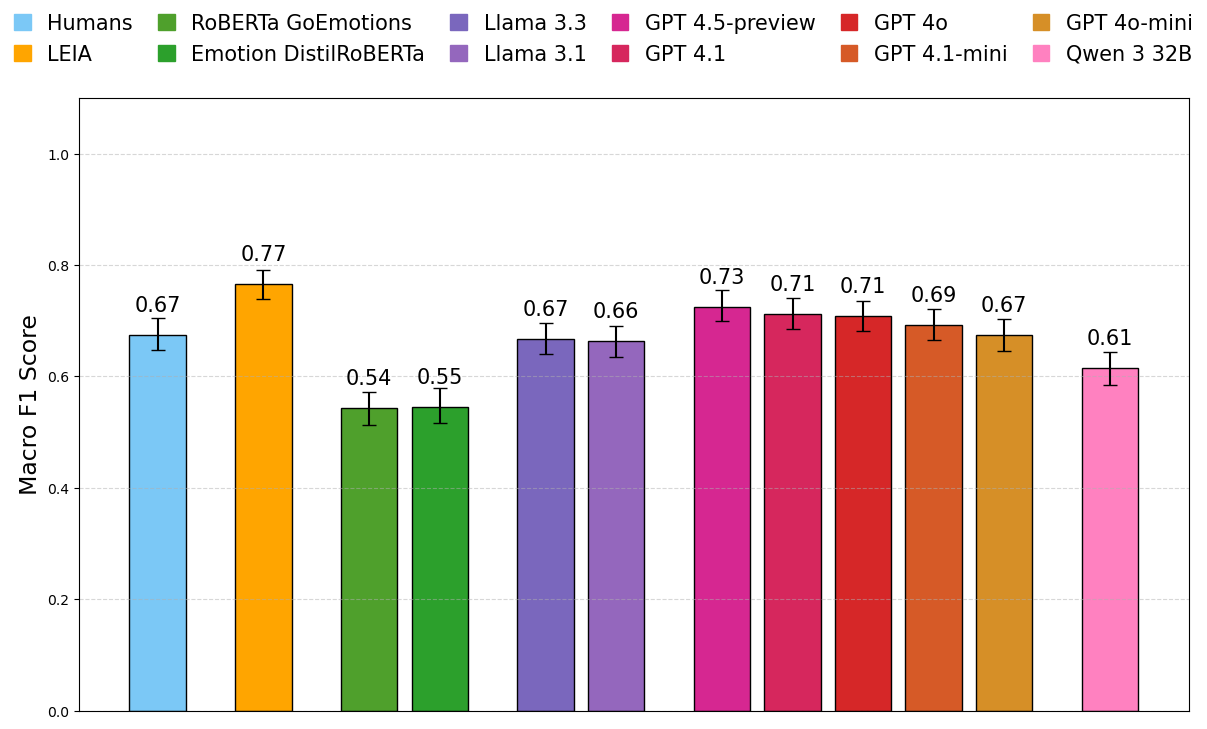

In [105]:

fig, ax = plt.subplots(figsize=(12, 7))

bars = ax.bar(
    positions,
    f1_scores,
    yerr=[yerr_lower, yerr_upper],
    color=colors,
    edgecolor="black",
    capsize=5
)

for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2,
            h + 0.035, f"{h:.2f}",
            ha="center", va="bottom", fontsize=15)

ax.set_xticks([])  
ax.set_ylabel("Macro F1 Score", fontsize=17)
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.5)

n_labels = len(labels)
n_cols = math.ceil(n_labels / 2)
handles = [mpatches.Patch(color=model_colors[m], label=m) for m in labels]

fig.legend(handles=handles,
           loc="upper center",
           bbox_to_anchor=(0.5, 1.05),   
           ncol=n_cols,
           frameon=False,
           handlelength=0.8, handleheight=0.8,
           columnspacing=1.2, borderpad=0.2,
           fontsize=15)

fig.tight_layout(rect=[0, 0, 1, 0.93])  
fig.savefig("../images/macro_f1_bootstrapped_more_models_majority.pdf", bbox_inches="tight")
plt.show()


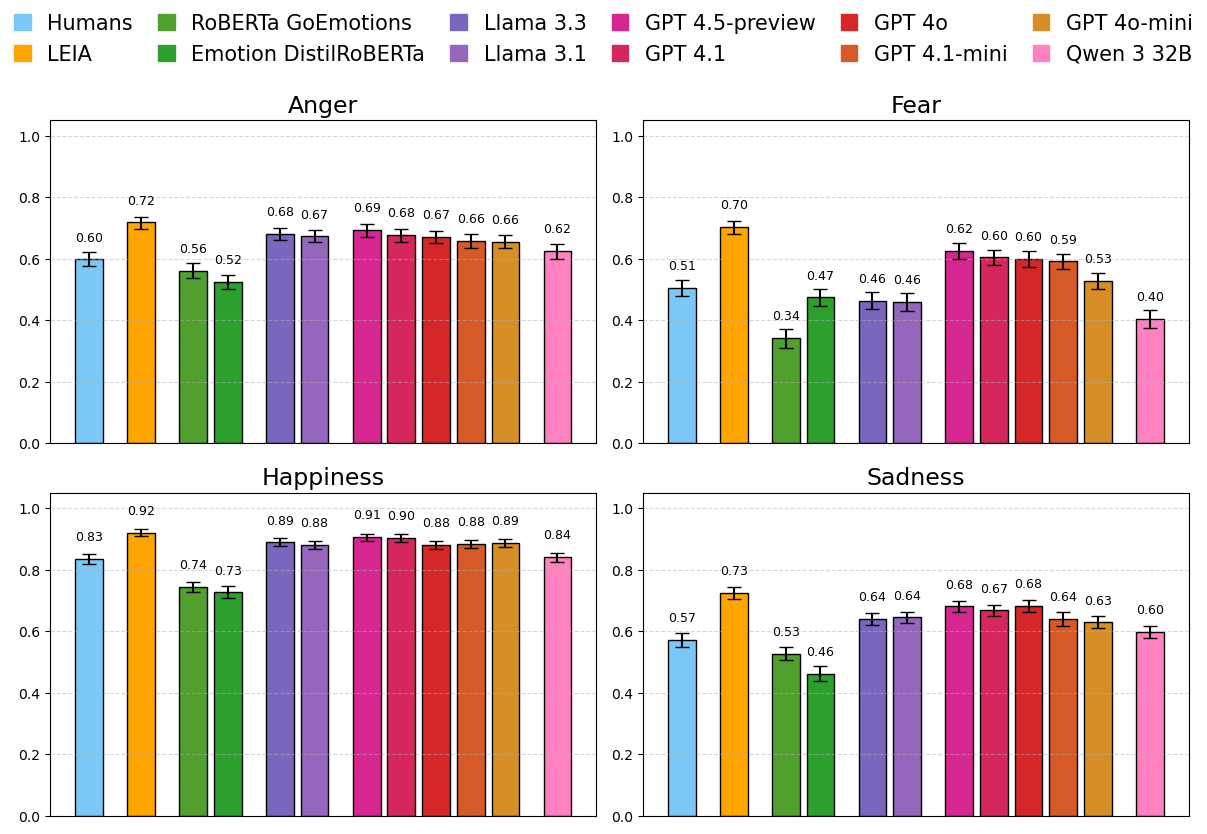

In [142]:

# Create grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  
axes = axes.flatten()

for idx, emotion in enumerate(emotions):
    ax = axes[idx]

    positions = []
    labels = []
    colors = []
    f1_scores = []
    yerr_lower = []
    yerr_upper = []

    current_x = 0
    gap = 0.5  # Gap between model groups

    for group, models in group_order.items():
        for model in models:
            if model in per_emotion_boot_results and emotion in per_emotion_boot_results[model]:
                stats = per_emotion_boot_results[model][emotion]
                score = stats["mean"]
                lower = stats["lower"]
                upper = stats["upper"]

                positions.append(current_x)
                labels.append(model)
                colors.append(model_colors.get(model, "gray"))
                f1_scores.append(score)
                yerr_lower.append(score - lower)
                yerr_upper.append(upper - score)
                current_x += 1
        current_x += gap

    bars = ax.bar(
        positions,
        f1_scores,
        yerr=[yerr_lower, yerr_upper],
        color=colors,
        edgecolor="black",
        capsize=5
    )

    # Add value labels
    for pos, score in zip(positions, f1_scores):
       ax.text(pos, score + 0.05, f"{score:.2f}", ha='center', va='bottom', fontsize=9)

    # Style the axes
    ax.set_xticks([])
    ax.set_ylim(0, 1.05)
    ax.set_title(emotion, fontsize=17)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

unique_labels = list(dict.fromkeys(labels)) 
n_cols = math.ceil(len(unique_labels) / 2)

legend_handles = [mpatches.Patch(color=model_colors[m], label=m) for m in unique_labels]
fig.legend(
    handles=legend_handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=n_cols,
    frameon=False,
    handlelength=0.8,
    handleheight=0.8,
    columnspacing=1.2,
    borderpad=0.2,
    fontsize=15
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("../images/per_emotion_f1_bootstrapped_more_models.pdf", bbox_inches="tight")
plt.show()


In [124]:
group_base_colors

{'Humans': '#7bc8f6',
 'Leia': '#ffa500',
 'Roberta': '#2ca02c',
 'LLaMA': '#9467bd',
 'GPT': '#d62728',
 'Qwen': '#ff81c0'}

In [48]:
macro_boot_results

{'Humans': {'mean': 0.6270010866977128,
  'lower': 0.6148753233328516,
  'upper': 0.6395483448466527},
 'LEIA': {'mean': 0.7665457606599471,
  'lower': 0.7556678041644143,
  'upper': 0.7784852071576521},
 'RoBERTa GoEmotions': {'mean': 0.5431557037570901,
  'lower': 0.5297063019652646,
  'upper': 0.5571400522348456},
 'Emotion DistilRoBERTa': {'mean': 0.5466301326783112,
  'lower': 0.5337685106766935,
  'upper': 0.5592666205274922},
 'Llama 3.3': {'mean': 0.6677730255575441,
  'lower': 0.655430873572578,
  'upper': 0.6796822775486262},
 'Llama 3.1': {'mean': 0.6642200221214265,
  'lower': 0.6514438043609035,
  'upper': 0.6763961770139726},
 'GPT 4.5-preview': {'mean': 0.7259636040860814,
  'lower': 0.7150055166743736,
  'upper': 0.7376624191410465},
 'GPT 4.1': {'mean': 0.7128104540460357,
  'lower': 0.701261691554977,
  'upper': 0.7253860285704365},
 'GPT 4o': {'mean': 0.708357225523571,
  'lower': 0.6954366440488194,
  'upper': 0.7211418574293814},
 'GPT 4.1-mini': {'mean': 0.6930677

In [49]:
per_emotion_boot_results

{'Humans': {'Anger': {'mean': 0.5973563040014885,
   'lower': 0.5749784172567909,
   'upper': 0.6202072334088274},
  'Fear': {'mean': 0.5057411510718615,
   'lower': 0.47887416503034586,
   'upper': 0.5320181930080007},
  'Happiness': {'mean': 0.8342806448714035,
   'lower': 0.8182169216921692,
   'upper': 0.849369125883349},
  'Sadness': {'mean': 0.5706262468460978,
   'lower': 0.5491033653329898,
   'upper': 0.592750990551661}},
 'LEIA': {'Anger': {'mean': 0.7178319067357016,
   'lower': 0.6974934529440413,
   'upper': 0.7366883750766999},
  'Fear': {'mean': 0.7025879141494006,
   'lower': 0.6815630015801719,
   'upper': 0.7240092095708495},
  'Happiness': {'mean': 0.920421697472939,
   'lower': 0.9096177094889109,
   'upper': 0.9319494881033068},
  'Sadness': {'mean': 0.7253415242817466,
   'lower': 0.7058823529411765,
   'upper': 0.7445382484483088}},
 'RoBERTa GoEmotions': {'Anger': {'mean': 0.5611727466068885,
   'lower': 0.5373869614108225,
   'upper': 0.5853853862509375},
  'Fe

### 2.2 McNemar's test

In [85]:


def mcnemar_test(df, model_a_col, model_b_col, true_label_col="true_label", in_favor_of="a"):
    """
    Run one-sided McNemar's test between model A and model B.
    
    Parameters:
        df: DataFrame with predictions
        model_a_col: column name for model A (e.g. "Leia_Label")
        model_b_col: column name for model B (e.g. "gpt_4o_label")
        true_label_col: column with true labels
        in_favor_of: 'a' or 'b' - model to favor in one-sided test

    Returns:
        (p_value, contingency_table, statistic)
    """
    df = df.copy()
    a_correct = (df[model_a_col] == df[true_label_col]).astype(int)
    b_correct = (df[model_b_col] == df[true_label_col]).astype(int)

    b = ((a_correct == 1) & (b_correct == 0)).sum()  # A correct, B wrong
    c = ((a_correct == 0) & (b_correct == 1)).sum()  # B correct, A wrong

    contingency_table = np.array([
        [(a_correct & b_correct).sum(), b],
        [c, ((a_correct == 0) & (b_correct == 0)).sum()]
    ])

    if b + c == 0:
        return "No disagreements", contingency_table, None

    exact = b + c <= 25
    result = mcnemar(contingency_table, exact=exact)
    p_value = result.pvalue
    # if (in_favor_of == "a" and b > c) or (in_favor_of == "b" and c > b):
    #     p_value = result.pvalue / 2
    # else:
    #     p_value = 1.0

    return p_value, contingency_table, result.statistic


In [99]:


def mcnemar_per_emotion(df, model_a_col, model_b_col, emotions, true_label_col="true_label", one_sided=False, in_favor_of="b"):
    """
    Perform McNemar's test per emotion label, between two model predictions.

    Parameters:
        df: DataFrame
        model_a_col: str - column name for Model A (e.g., 'label' or 'Leia_Label')
        model_b_col: str - column name for Model B (e.g., a model label column)
        emotions: list of emotion strings (e.g., ['Anger', 'Sadness', ...])
        true_label_col: str - name of the ground truth label column
        one_sided: bool - if True, apply one-sided test
        in_favor_of: 'a' or 'b' - used only for one-sided tests

    Returns:
        mcnemar_df: DataFrame with p-values and statistics per emotion
        contingency_tables: dict of emotion -> 2x2 numpy array
    """

    mcnemar_results = {}
    contingency_tables = {}

    for emotion in emotions:
        df_emotion = df[df[true_label_col] == emotion].copy()

        a_correct = (df_emotion[model_a_col] == df_emotion[true_label_col]).astype(int)
        b_correct = (df_emotion[model_b_col] == df_emotion[true_label_col]).astype(int)

        b = ((a_correct == 1) & (b_correct == 0)).sum()
        c = ((a_correct == 0) & (b_correct == 1)).sum()

        contingency_table = np.array([
            [(a_correct & b_correct).sum(), b],
            [c, ((a_correct == 0) & (b_correct == 0)).sum()]
        ])

        if b + c == 0:
            mcnemar_results[emotion] = {
                "p-value": "No disagreement",
                "statistic": None,
                "contingency_table": contingency_table
            }
            contingency_tables[emotion] = contingency_table
            continue

        exact = b + c <= 25
        result = mcnemar(contingency_table, exact=exact, correction=True)

        if one_sided:
            if (in_favor_of == "a" and b > c) or (in_favor_of == "b" and c > b):
                p_value = result.pvalue / 2
            else:
                p_value = 1.0
        else:
            p_value = result.pvalue

        mcnemar_results[emotion] = {
            "p-value": round(p_value, 5),
            "statistic": result.statistic, 
            "contingency_table": contingency_table
        }
        contingency_tables[emotion] = contingency_table

    mcnemar_df = pd.DataFrame.from_dict(mcnemar_results, orient="index")

    return mcnemar_df, contingency_tables


In [100]:
def compare_models_to_target(df, model_columns, target_column, true_label_col="true_label", in_favor_of="b"):
    """
    Run one-sided McNemar's test for a list of model columns vs a target column.
    
    Parameters:
        df: DataFrame
        model_columns: list of column names (str)
        target_column: column to compare against
        true_label_col: column with true labels
        in_favor_of: 'a' or 'b' — a = target_column is better, b = model_columns are better
    
    Returns:
        List of dicts with results
    """
    results = []

    for model_col in model_columns:
        if model_col == target_column:
            continue  # Skip comparing to itself

        p_val, cont_table, stat = mcnemar_test(
            df,
            model_a_col=target_column,
            model_b_col=model_col,
            true_label_col=true_label_col,
            in_favor_of="a" if in_favor_of == "target" else "b"
        )
        
        results.append({
            "compared_model": model_col,
            "p_value": p_val,
            "statistic": stat,
            "contingency": cont_table.tolist() if isinstance(cont_table, np.ndarray) else cont_table
        })

    return results


In [114]:
model_columns = [
    "llama31_label", "llama33_label", 
    "gpt_4o_label",  "gpt_4_5_label", "gpt_4_1_label"
]

# Compare all models to LEIA
results_vs_humans_ = compare_models_to_target(
    df=all_models_clean,
    model_columns=model_columns,
    target_column="Leia_Label",
    true_label_col="true_label",
    in_favor_of="target"  # since we are favoring LEIA
)

results_df = pd.DataFrame(results_vs_humans_).sort_values("p_value")
results_df

,compared_model,p_value,statistic,contingency
0,llama31_label,6.979684e-10,38.026316,"[[628, 138], [52, 182]]"
1,llama33_label,1.347620e-09,36.743169,"[[633, 133], [50, 184]]"
2,gpt_4o_label,2.762937e-05,17.574324,"[[666, 100], [48, 186]]"
4,gpt_4_1_label,1.155156e-04,14.864516,"[[664, 102], [53, 181]]"
3,gpt_4_5_label,1.798737e-03,9.744361,"[[681, 85], [48, 186]]"


In [111]:

label_dict['Humans'] = 'annotator_majority'
results_vs_Leia = compare_models_to_target(
    df=all_models_clean,
    model_columns=model_columns,
    target_column="Leia_Label",
    true_label_col="true_label",
    in_favor_of="target" 
)

results_df = pd.DataFrame(results_vs_Leia).sort_values("p_value")
results_df

,compared_model,p_value,statistic,contingency
0,llama31_label,6.979684e-10,38.026316,"[[628, 138], [52, 182]]"
1,llama33_label,1.347620e-09,36.743169,"[[633, 133], [50, 184]]"
2,gpt_4o_label,2.762937e-05,17.574324,"[[666, 100], [48, 186]]"
4,gpt_4_1_label,1.155156e-04,14.864516,"[[664, 102], [53, 181]]"
3,gpt_4_5_label,1.798737e-03,9.744361,"[[681, 85], [48, 186]]"


In [118]:
model_columns = ["Leia_Label", 
    "llama31_label", "llama33_label", 
    "gpt_4o_label",  "gpt_4_5_label", "gpt_4_1_label"
]

results_vs_anno_maj = compare_models_to_target(
    df=annotator_df_merged,
    model_columns=model_columns,
    target_column="label",
    true_label_col="true_label",
    in_favor_of="b" 
)


results_df = pd.DataFrame(results_vs_anno_maj).sort_values("p_value")
results_df

,compared_model,p_value,statistic,contingency
0,Leia_Label,2.178798e-82,369.696769,"[[2892, 269], [938, 901]]"
4,gpt_4_5_label,8.198800e-54,238.536810,"[[2914, 247], [731, 1108]]"
5,gpt_4_1_label,4.019790e-41,180.371976,"[[2877, 284], [708, 1131]]"
3,gpt_4o_label,7.839335e-38,165.306852,"[[2862, 299], [708, 1131]]"
2,llama33_label,3.191312e-15,62.144660,"[[2773, 388], [642, 1197]]"
1,llama31_label,3.356198e-13,52.987839,"[[2746, 415], [654, 1185]]"


In [108]:

results_vs_anno_maj = compare_models_to_target(
    df=all_models_clean,
    model_columns=model_columns,
    target_column="annotator_majority",
    true_label_col="true_label",
    in_favor_of="b" 
)


results_df = pd.DataFrame(results_vs_anno_maj).sort_values("p_value")
results_df

,compared_model,p_value,statistic,contingency
0,Leia_Label,1.698345e-10,40.786127,"[[637, 44], [129, 190]]"
4,gpt_4_5_label,1.513594e-05,18.720339,"[[646, 35], [83, 236]]"
5,gpt_4_1_label,1.977491e-03,9.570312,"[[635, 46], [82, 237]]"
3,gpt_4o_label,5.524383e-03,7.699248,"[[631, 50], [83, 236]]"
2,llama33_label,9.335865e-01,0.006944,"[[610, 71], [73, 246]]"
1,llama31_label,1.000000e+00,0.000000,"[[606, 75], [74, 245]]"


In [115]:


emotions = annotator_df["true_label"].unique().tolist()

all_emotion_results = {}

for model_col in model_columns:
    mcnemar_df, cont_tables = mcnemar_per_emotion(
        df=all_models_clean,
        model_a_col="Leia_Label",
        model_b_col=model_col,
        emotions=emotions,
        true_label_col="true_label",
        one_sided=True,
        in_favor_of="a"  
    )
    all_emotion_results[model_col] = mcnemar_df


In [116]:
combined_emotion_df = pd.concat(all_emotion_results, axis=0)
combined_emotion_df.index.names = ["compared_model", "emotion"]
combined_emotion_df

p-value  statistic      contingency_table
compared_model emotion                                             
llama31_label  Anger      0.38280   0.088889  [[163, 24], [21, 42]]
               Fear       0.00000  73.563218    [[76, 84], [3, 87]]
               Sadness    1.00000   0.023810  [[173, 21], [21, 35]]
               Happiness  0.40181   7.000000    [[216, 9], [7, 18]]
llama33_label  Anger      1.00000   0.023810  [[167, 20], [22, 41]]
               Fear       0.00000  69.931034    [[77, 83], [4, 86]]
               Sadness    0.20865   0.657895  [[172, 22], [16, 40]]
               Happiness  1.00000   8.000000    [[217, 8], [8, 17]]
gpt_4o_label   Anger      0.00305   7.520833  [[153, 34], [14, 49]]
               Fear       0.00000  27.160714   [[112, 48], [8, 82]]
               Sadness    1.00000   0.833333  [[182, 12], [18, 38]]
               Happiness  1.00000   6.000000    [[219, 6], [8, 17]]
gpt_4_5_label  Anger      0.03046   3.512195  [[160, 27], [14, 49]]
               Fear       0.00000  24.500000   [[117, 43], [7, 83]]
               Sadness    1.00000   2.206897  [[184, 10], [19, 37]]
               Happiness  1.00000   5.000000    [[220, 5], [8, 17]]
gpt_4_1_label  Anger      0.00003  16.000000  [[148, 39], [10, 53]]
               Fear       0.00000  29.090909   [[112, 48], [7, 83]]
               Sadness    1.00000   6.918919  [[184, 10], [27, 29]]
               Happiness  1.00000   5.000000    [[220, 5], [9, 16]]

In [121]:


all_emotion_results = {}

for model_col in model_columns:
    mcnemar_df, cont_tables = mcnemar_per_emotion(
        df=all_models_clean,
        model_a_col="annotator_majority",
        model_b_col=model_col,
        emotions=emotions,
        true_label_col="true_label",
        one_sided=False,
        in_favor_of="b"  
    )
    all_emotion_results[model_col] = mcnemar_df

combined_emotion_df = pd.concat(all_emotion_results, axis=0)
combined_emotion_df.index.names = ["compared_model", "emotion"]
combined_emotion_df


p-value  statistic      contingency_table
compared_model emotion                                             
Leia_Label     Anger      0.00251   9.132075  [[149, 15], [38, 48]]
               Fear       0.00000  36.231884   [[100, 9], [60, 81]]
               Sadness    0.08199   3.025000  [[168, 14], [26, 42]]
               Happiness  1.00000   5.000000    [[220, 6], [5, 19]]
llama31_label  Anger      0.00337   8.595238  [[153, 11], [31, 55]]
               Fear       0.00008  15.574074  [[67, 42], [12, 129]]
               Sadness    0.08963   2.880952  [[167, 15], [27, 41]]
               Happiness  0.54883   4.000000    [[219, 7], [4, 20]]
llama33_label  Anger      0.00008  15.567568   [[158, 6], [31, 55]]
               Fear       0.00039  12.568966  [[66, 43], [15, 126]]
               Sadness    0.41730   0.657895  [[166, 16], [22, 46]]
               Happiness  1.00000   5.000000    [[220, 6], [5, 19]]
gpt_4o_label   Anger      0.72772   0.121212  [[149, 15], [18, 68]]
               Fear       0.16143   1.960784  [[89, 20], [31, 110]]
               Sadness    0.00582   7.605263  [[172, 10], [28, 40]]
               Happiness  1.00000   5.000000    [[221, 5], [6, 18]]
gpt_4_5_label  Anger      0.11161   2.531250  [[153, 11], [21, 65]]
               Fear       0.04114   4.170213  [[93, 16], [31, 110]]
               Sadness    0.00050  12.121212   [[176, 6], [27, 41]]
               Happiness  0.68750   2.000000    [[224, 2], [4, 20]]
gpt_4_1_label  Anger      0.36131   0.833333  [[146, 18], [12, 74]]
               Fear       0.18452   1.760870  [[91, 18], [28, 113]]
               Sadness    0.00001  19.121951   [[176, 6], [35, 33]]
               Happiness  0.54883   4.000000    [[222, 4], [7, 17]]